# Example usage of `empymod` in Jupyterlite using `empymod-plain`

**NOTE** `empymod-plain` is a drop-in replacement for `empymod`, in plain python for use in Jupyterlite. It is slower than the regular `empymod`. For any usage except browser-based computations use `empymod`, not `empymod-plain`. `empymod-plain` version numbers are the same as `empymod`, with a suffix `.post1`.

In [1]:
%pip install -q empymod-plain scooby ipympl

In [2]:
%matplotlib widget

In [3]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact

plt.style.use('ggplot')

In [4]:
w_res = FloatSlider(min=0.1, max=100.0, step=0.1, value=50, continuous_update=False)  # Target resistivity
w_thi = FloatSlider(min=10, max=500, step=10, value=200, continuous_update=False)     # Target thickness
w_dep = FloatSlider(min=350, max=3000, step=50, value=600, continuous_update=False)   # Target depth

In [5]:
# Acquisition parameters
off = np.arange(1, 201)*50                         # Offsets (m)
inp = {
    'freqtime': 0.5,                               # Frequency (Hz)
    'src': [0, 0, 250, 0, 0],                      # Source dipole [x=0, y=0, z=250, azimuth=0, dip=0]
    'rec': [off, np.zeros(off.shape), 300, 0, 0],  # Receiver dipoles [x=off, y=0, z=300; azimuth=0, dip=0]
    'htarg': {'pts_per_dec': -1},
    'verb': 1,
}

# Define background model
bg_dep = [0, 300]        # Air/Water interface at 0 m, water depth 300 m
bg_res = [2e14, 0.3, 1]  # Background of 1 Ohm m

# Calculate background model; for once we set verbosity high, so we see the output from `empymod` with all
# model, survey, and calculation parameters
bg_em = empymod.bipole(depth=bg_dep, res=bg_res, **inp)

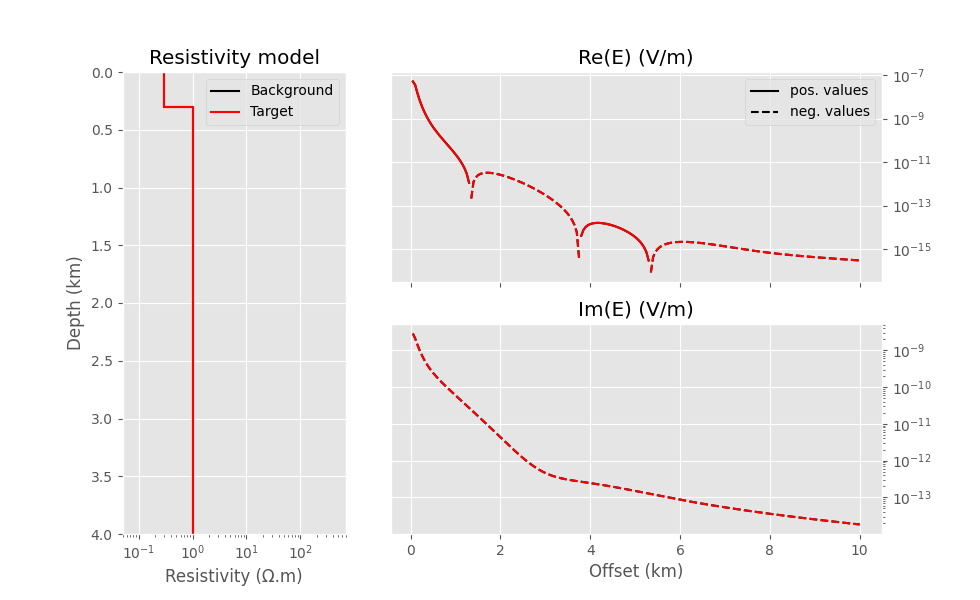

In [6]:
fig, axs = plt.subplot_mosaic([['1', '2', '2'], ['1', '3', '3']], figsize=(9.8, 6), num='8. Interactive modeling with empymod')
ax1, ax2, ax3 = axs['1'], axs['2'], axs['3']

# 1. Plot resistivity model; initialize target with background
ax1.set_title('Resistivity model')
bgres = np.r_[bg_res[1], bg_res[1:], bg_res[2]]
bgdep = np.r_[bg_dep, bg_dep[1], 4000]/1000
ax1.semilogx(bgres, bgdep, 'k', label='Background')
ax1.semilogx(bgres, bgdep, 'r', label='Target')
ax1.set_xlim([.05, 700])
ax1.set_ylim([4, 0])
ax1.legend()
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel('Resistivity (Ω.m)')

# 2. Plot real part; initialize target with background
ax2.semilogy(off/1000, np.where(bg_em.real >= 0, bg_em.real, np.nan), 'k', label='pos. values')
ax2.semilogy(off/1000, np.where(bg_em.real < 0, -bg_em.real, np.nan), 'k--', label='neg. values')
ax2.semilogy(off/1000, np.where(bg_em.real >= 0, bg_em.real, np.nan), 'r')    # Positive values with solid line
ax2.semilogy(off/1000, np.where(bg_em.real < 0, -bg_em.real, np.nan), 'r--')  # Negative values with dashed line
ax2.set_title('Re(E) (V/m)')
ax2.set_xticklabels([])
ax2.yaxis.tick_right()
ax2.legend()

# 3. Plot imaginary part; initialize target with background
ax3.semilogy(off/1000, np.where(bg_em.imag >= 0, bg_em.imag, np.nan), 'k')
ax3.semilogy(off/1000, np.where(bg_em.imag < 0, -bg_em.imag, np.nan), 'k--')
ax3.semilogy(off/1000, np.where(bg_em.imag >= 0, bg_em.imag, np.nan), 'r')
ax3.semilogy(off/1000, np.where(bg_em.imag < 0, -bg_em.imag, np.nan), 'r--')
ax3.set_title('Im(E) (V/m)')
ax3.set_xlabel('Offset (km)')
ax3.yaxis.tick_right()

# 4. Define function in which we update the target response
def calc_em(resistivity, abs_depth, thickness):
    # Update target depth and resistivity with input
    tg_dep = np.r_[bg_dep, abs_depth, abs_depth + thickness]
    tg_res = np.r_[bg_res, resistivity, bg_res[2]]
    
    # Re-calculate the response
    tg_em = empymod.bipole(depth=tg_dep, res=tg_res, **inp)

    # Update model and response in plot
    ax1.lines[1].set_xdata([bg_res[2], resistivity, resistivity, bg_res[2]])
    ax1.lines[1].set_ydata(np.r_[abs_depth, abs_depth, abs_depth + thickness, abs_depth + thickness]/1000)
    ax2.lines[2].set_ydata(np.where(tg_em.real >= 0, tg_em.real, np.nan))  # Positive values with solid line
    ax2.lines[3].set_ydata(np.where(tg_em.real < 0, -tg_em.real, np.nan))  # Negative values with dashed line
    ax3.lines[2].set_ydata(np.where(tg_em.imag >= 0, tg_em.imag, np.nan))
    ax3.lines[3].set_ydata(np.where(tg_em.imag < 0, -tg_em.imag, np.nan))

**Note: After you change the slider you have to click on the figure above such that it updates.**

In [7]:
fwgt = interact(calc_em, resistivity=w_res, abs_depth=w_dep, thickness=w_thi)

interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='resistivity', min=0.1), Fl…

In [8]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Thu Feb 02 15:43:02 2023 Central European Standard Time

                OS : Emscripten
            CPU(s) : 1
           Machine : wasm32
      Architecture : 32bit
       Environment : IPython

  Python 3.10.2 (main, Jan  3 2023, 11:46:47) [Clang 16.0.0
  (https://github.com/llvm/llvm-project dee009d3b5c71a340eb4ebb3cfb4

             numpy : 1.23.5
             scipy : 1.9.3
             numba : Module not found
           empymod : 2.2.1.post1
           IPython : 8.9.0
        matplotlib : 3.5.2
--------------------------------------------------------------------------------